In [1]:
import cv2
import numpy as np
import os
import pickle
from amftrack.util.sys import (
    test_path,
    get_current_folders,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
)
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.util.dbx import get_dropbox_folders, get_dropbox_folders

from amftrack.pipeline.launching.run import run_transfer
from amftrack.pipeline.functions.post_processing.area_hulls import get_regular_hulls_area_fixed

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from shapely import affinity
from shapely.geometry.multipolygon import MultiPolygon
from scipy.spatial import Voronoi

# Voronoi doesn't work properly with points below (0,0) so set lowest point to (0,0)




def shape_to_points(shape, num = 10, smaller_versions = 10):
    points = []

    # Take the shape, shrink it by a factor (first iteration factor=1), and then 
    # take points around the contours
    for shrink_factor in range(0,smaller_versions,1):
        # calculate the shrinking factor
        shrink_factor = smaller_versions - shrink_factor
        shrink_factor = shrink_factor / float(smaller_versions)
        # actually shrink - first iteration it remains at 1:1
        smaller_shape = affinity.scale(shape, shrink_factor, shrink_factor)
        # Interpolate numbers around the boundary of the shape
        for i in range(0,int(num*shrink_factor),1):
            i = i / int(num*shrink_factor)
            x,y =  smaller_shape.interpolate(i, normalized=True).xy
            points.append( (x[0],y[0]))
    
    # add the origin
    x,y = smaller_shape.centroid.xy
    points.append( (x[0], y[0]) ) # near, but usually not add (0,0)
    
    points = np.array(points)
    return points


def points_to_voronoi(points):
    vor = Voronoi(points)
    vertices = [ x for x in vor.ridge_vertices if -1 not in x]
    # For some reason, some vertices were seen as super, super long. Probably also infinite lines, so take them out
    lines = [ LineString(vor.vertices[x]) for x in vertices if not vor.vertices[x].max() > 50000]
    return MultiLineString(lines)

In [4]:
from shapely.geometry import Polygon
shape = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])

In [6]:
from shapely.geometry import LineString, MultiPolygon, Polygon
from shapely.ops import split

def splitPolygon(polygon, nx, ny):
    minx, miny, maxx, maxy = polygon.bounds
    dx = (maxx - minx) / nx
    dy = (maxy - miny) / ny

    minx, miny, maxx, maxy = polygon.bounds
    dx = (maxx - minx) / nx  # width of a small part
    dy = (maxy - miny) / ny  # height of a small part
    horizontal_splitters = [LineString([(minx, miny + i*dy), (maxx, miny + i*dy)]) for i in range(ny)]
    vertical_splitters = [LineString([(minx + i*dx, miny), (minx + i*dx, maxy)]) for i in range(nx)]
    splitters = horizontal_splitters + vertical_splitters
    result = polygon
    
    for splitter in splitters:
        result = MultiPolygon(split(result, splitter))
    
    return result


2023-03-09 16:33:03,211-[INFO]- shapely.geos:296 -> Self-intersection at or near point 0.33333333333333331 0


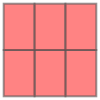

In [8]:
splitPolygon(shape,3,2)